### Query ORCID for all people affiliated with an organization and filter for current employees only

This notebook queries the ORCID API for all people affiliated with an organization. It takes a ROR URL as input and outputs all ORCIDs belonging to people affiliated with the respective organization. Additionally the affiliation is narrowed down to people **currently employed** by the organization.

In [ ]:
# needed dependency to make HTTP calls
import requests
# dependencies for dealing with json
import pprint
!pip install python-benedict
from benedict import benedict

### Organization metadata
First we retrieve the metadata associated with an organization. The input value for the computation is a ROR id or ROR URL.

In [2]:
example_ror="https://ror.org/04aj4c181"

The first step is to call the ROR API for the organization's metadata.

In [3]:
# URL for ROR API
ROR_API_ENDPOINT = "https://api.ror.org/organizations"

# query ROR API for organization's metadata
def query_ror_api(ror):
  response = requests.get(url=requests.utils.requote_uri(ROR_API_ENDPOINT + "/" + ror),
                          headers={'Content-Type': 'application/json'})
  result=response.json()

  return result

# example execution
ror_data=query_ror_api(example_ror)
pprint.pprint(ror_data)

{'acronyms': ['TIB'],
 'addresses': [{'city': 'Hanover',
                'country_geonames_id': 2921044,
                'geonames_city': {'city': 'Hannover',
                                  'geonames_admin1': {'ascii_name': 'Lower '
                                                                    'Saxony',
                                                      'code': 'DE.06',
                                                      'id': 2862926,
                                                      'name': 'Lower Saxony'},
                                  'geonames_admin2': {'ascii_name': None,
                                                      'code': None,
                                                      'id': None,
                                                      'name': None},
                                  'id': 2910831,
                                  'license': {'attribution': 'Data from '
                                                             'geona

In particular we are interested in the organization's grid ID and Wikidata ID.

In [4]:
def extract_grid_from_ror_data(ror_data):
  orga_dict = benedict.from_json(ror_data)
  path_to_grid_id = "external_ids.GRID.all"
  grid_id = orga_dict.get(path_to_grid_id)
  return grid_id

def extract_wikidata_from_ror_data(ror_data):
  orga_dict = benedict.from_json(ror_data)
  path_to_wikidata_id = "external_ids.Wikidata.all[0]"
  wikidata_id = orga_dict.get(path_to_wikidata_id)
  return wikidata_id


# example execution
organization_grid_id=extract_grid_from_ror_data(ror_data)
print("grid ID: " + organization_grid_id)
organization_wikidata_id=extract_wikidata_from_ror_data(ror_data)
print("Wikidata ID: " + organization_wikidata_id)

grid ID: grid.461819.3
Wikidata ID: Q2399120


We use the Wikidata ID of the organization to query Wikidata for the Ringgold ID of the organization.

In [5]:
WIKIDATA_API = "https://www.wikidata.org/w/api.php"

# query Wikidata with an organization's Wikidata ID
def query_wikidata_api(wikidata_id):

  response = requests.get(url=WIKIDATA_API,
                          params={'action': 'wbgetentities', 'ids': wikidata_id, 'props':'claims', 'format':'json'},
                          headers={'Content-Type': 'application/json'})
  result=response.json()
  return result

def extract_ringgold_from_wikidata_data(wikidata, wikidata_id):
  wikidata_dict = benedict.from_json(wikidata)
  path_to_ringgold_id = f"entities.{wikidata_id}.claims.P3500[0].mainsnak.datavalue.value"
  ringgold_id = wikidata_dict.get(path_to_ringgold_id)
  return ringgold_id


# example execution
wikidata_data = query_wikidata_api(organization_wikidata_id)
#pprint.pprint(wikidata_data)
organization_ringgold_id = extract_ringgold_from_wikidata_data(wikidata_data, organization_wikidata_id)
print("Ringgold ID: " + str(organization_ringgold_id or ''))

Ringgold ID: 28359


To sum up the process up until now:
1.   We used an organization's ROR ID to query the ROR API for an organization's grid ID and Wikidata ID. 
2. We use Wikidata as intermediary to retrieve the Ringgold ID of the organization.

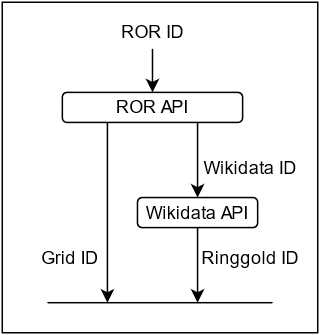

### Connection organization -> people
The second part of the process is to query for the people affiliated with the organization. For this we use the ORCID API and search for people affiliated with an organization like it is explained in the ORCID tutorial ["How do I find ORCID record holders at my institution?"](https://info.orcid.org/faq/how-do-i-find-orcid-record-holders-at-my-institution/). As parameters for the query we use the Grid ID and Ringgold ID for the organization.


In [6]:
ORCID_SEARCH_API = "https://pub.orcid.org/v3.0/search/"

# query ORCID with an organization's Grid ID and Ringgold
def query_orcid_for_affiliations(grid_id, ringgold_id):
  query = f"grid-org-id:{grid_id}" if grid_id else ""
  query += " OR " if grid_id and ringgold_id else ""
  query += f"ringgold-org-id:{ringgold_id}" if ringgold_id else ""

  response = requests.get(url=ORCID_SEARCH_API,
                          params={'q': query},
                          headers={'Content-Type': 'application/json', 'Accept': 'application/json'})
  result=response.json()
  return result

def extract_orcids_from_affiliated_people(affiliated_people):
  people_dict = benedict.from_json(affiliated_people)
  for person in people_dict.get('result'):
    orcid=benedict(person).get('orcid-identifier.path')
    yield orcid

# example execution
affiliated_people = query_orcid_for_affiliations(organization_grid_id, organization_ringgold_id)
#pprint.pprint(affiliated_people)
print(f"Number of affiliated people: {affiliated_people.get('num-found','')}")
affiliated_orcids= extract_orcids_from_affiliated_people(affiliated_people)
for orcid in affiliated_orcids:
  print(orcid)

Number of affiliated people: 89
0000-0003-3922-8638
0000-0002-5610-9908
0000-0003-2749-7988
0000-0001-9758-904X
0000-0003-2718-0913
0000-0002-2614-1253
0000-0002-1266-4029
0000-0003-0929-7528
0000-0002-4311-5620
0000-0001-5135-5758
0000-0002-3680-2086
0000-0001-7408-0611
0000-0002-6347-5666
0000-0002-2874-4832
0000-0001-5375-3063
0000-0003-1574-4865
0000-0002-4450-349X
0000-0001-5322-0478
0000-0002-1407-7362
0000-0001-5336-6899
0000-0001-5492-3212
0000-0003-1668-3304
0000-0002-6802-1241
0000-0001-9248-5444
0000-0003-2257-0517
0000-0002-3060-7052
0000-0001-5693-4708
0000-0002-0938-0340
0000-0002-0698-2864
0000-0003-2510-0529
0000-0002-2342-0636
0000-0002-9362-4968
0000-0003-3320-5187
0000-0002-0021-9729
0000-0003-0524-1834
0000-0001-8824-8390
0000-0002-7760-5708
0000-0002-0719-5440
0000-0003-1537-2862
0000-0001-6260-7578
0000-0002-5320-0220
0000-0003-1132-7220
0000-0002-0474-2410
0000-0002-3278-0422
0000-0002-3447-0575
0000-0002-1851-0442
0000-0002-7917-3101
0000-0002-1442-335X
0000-000

The connection between organization and people via their affiliation as defined by the ORCID API is quite abroad: 

*   It contains each person that used the organization identifier in one of the sections [employment, education & qualifications, membership & service, invited positions & distinctions](https://info.orcid.org/documentation/integration-guide/working-with-organization-identifiers/) in their ORCID record.
* Furthermore the connection is not limited to the current affiliation but also contains people that were affiliated with the organization years ago.

--> 

That's why we decided to use the ORCIDs we retrieve via the search API and query the ORCID API for each of their detailed record to narrow the result set down to only people who 
* use one of the organization's IDs in the employment section
* and that are currently employed (end-date of employment is empty)

In [7]:
ORCID_RECORD_API = "https://pub.orcid.org/v3.0/"

# query ORCID for an ORCID record
def query_orcid_for_record(orcid_id):

  response = requests.get(url=requests.utils.requote_uri(ORCID_RECORD_API + orcid_id),
                          headers={'Content-Type': 'application/json', 'Accept': 'application/json'})
  result=response.json()
  return result

# check if affiliated person is a current employee
def is_current_employee(orcid_id, grid_id, ringgold_id):
  # get orcid record
  orcid_record = query_orcid_for_record(orcid_id)

  #filter for current employees only
  record_dict = benedict.from_json(orcid_record)
  path_to_employments = "activities-summary.employments.affiliation-group"
  for employment in record_dict.get(path_to_employments):
    employment_dict = benedict(employment)
    path_to_orga_id = "summaries[0].employment-summary.organization.disambiguated-organization.disambiguated-organization-identifier"
    path_to_end_date = "summaries[0].employment-summary.end-date"

    orga_id = employment_dict.get(path_to_orga_id)
    end_date = employment_dict.get(path_to_end_date)

    return not end_date and (orga_id == grid_id or orga_id == ringgold_id)


# example execution
affiliated_orcids = extract_orcids_from_affiliated_people(affiliated_people)
employee_orcids = [orcid_id for orcid_id in affiliated_orcids if is_current_employee(orcid_id, organization_grid_id, organization_ringgold_id)]
print(f"Number of current employees: {len(employee_orcids)}")
for orcid_id in employee_orcids:
  print(orcid_id)

Number of current employees: 59
0000-0003-3922-8638
0000-0002-5610-9908
0000-0003-2749-7988
0000-0001-9758-904X
0000-0003-2718-0913
0000-0002-2614-1253
0000-0003-0929-7528
0000-0001-5135-5758
0000-0002-3680-2086
0000-0002-6347-5666
0000-0002-2874-4832
0000-0001-5375-3063
0000-0003-1574-4865
0000-0001-5322-0478
0000-0002-1407-7362
0000-0001-5336-6899
0000-0001-5492-3212
0000-0002-6802-1241
0000-0001-9248-5444
0000-0002-3060-7052
0000-0002-0938-0340
0000-0002-0698-2864
0000-0003-2510-0529
0000-0002-2342-0636
0000-0002-9362-4968
0000-0001-8824-8390
0000-0002-0719-5440
0000-0001-6260-7578
0000-0003-1132-7220
0000-0002-0474-2410
0000-0002-3278-0422
0000-0002-3447-0575
0000-0002-1851-0442
0000-0002-7917-3101
0000-0002-1442-335X
0000-0002-5124-0165
0000-0003-3184-5930
0000-0003-1702-8707
0000-0001-8080-5308
0000-0002-1452-9509
0000-0002-8579-9717
0000-0002-1019-9151
0000-0003-4040-9073
0000-0003-0226-3608
0000-0001-8920-7515
0000-0002-2593-8754
0000-0001-6836-1193
0000-0003-0232-7085
0000-000

--> For this example we were able to narrow down the result from 89 affiliated people to 59 currently employed people.